In [13]:
#with: https://www.youtube.com/watch?v=ZLIPkmmDJAc&ab_channel=NicholasRenotte
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np

In [14]:
print(tf.__version__)

2.11.0


In [15]:
tf.config.list_physical_devices('GPU') 

[]

In [16]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Load Data

In [17]:
def LoadData(folder):
    nums = []
    for dirr in os.listdir(folder):
        if dirr[0] == 'Z':
            try:
                num = int(dirr[1:])
                nums.append(num) #is sorted like a string
            except ValueError:
                print('err: Check directory names')
                continue
            path = os.path.join(folder, dirr)
            audio_files = tf.data.Dataset.list_files(path+'\*.wav')
            #add labels:
            audio_labeled = tf.data.Dataset.zip((audio_files, tf.data.Dataset.from_tensor_slices(num*tf.ones(len(audio_files)))))
            try:
                data = data.concatenate(audio_labeled)
            except NameError:
                data = audio_labeled
    return data, nums

Prepare  data

In [18]:

data, nums = LoadData('Home_data')
batch_size = len(nums)
print(f'Total: {len(data)}')
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(batch_size)
data = data.prefetch(8)

batch_n = len(data)
test_n = batch_n//4
train_n = batch_n - test_n
print(f'Batches: {batch_n}\n Train: {train_n}\n Test: {test_n}')
train = data.take(train_n)
test = data.skip(train_n).take(test_n)

Total: 1987
Batches: 45
 Train: 34
 Test: 11


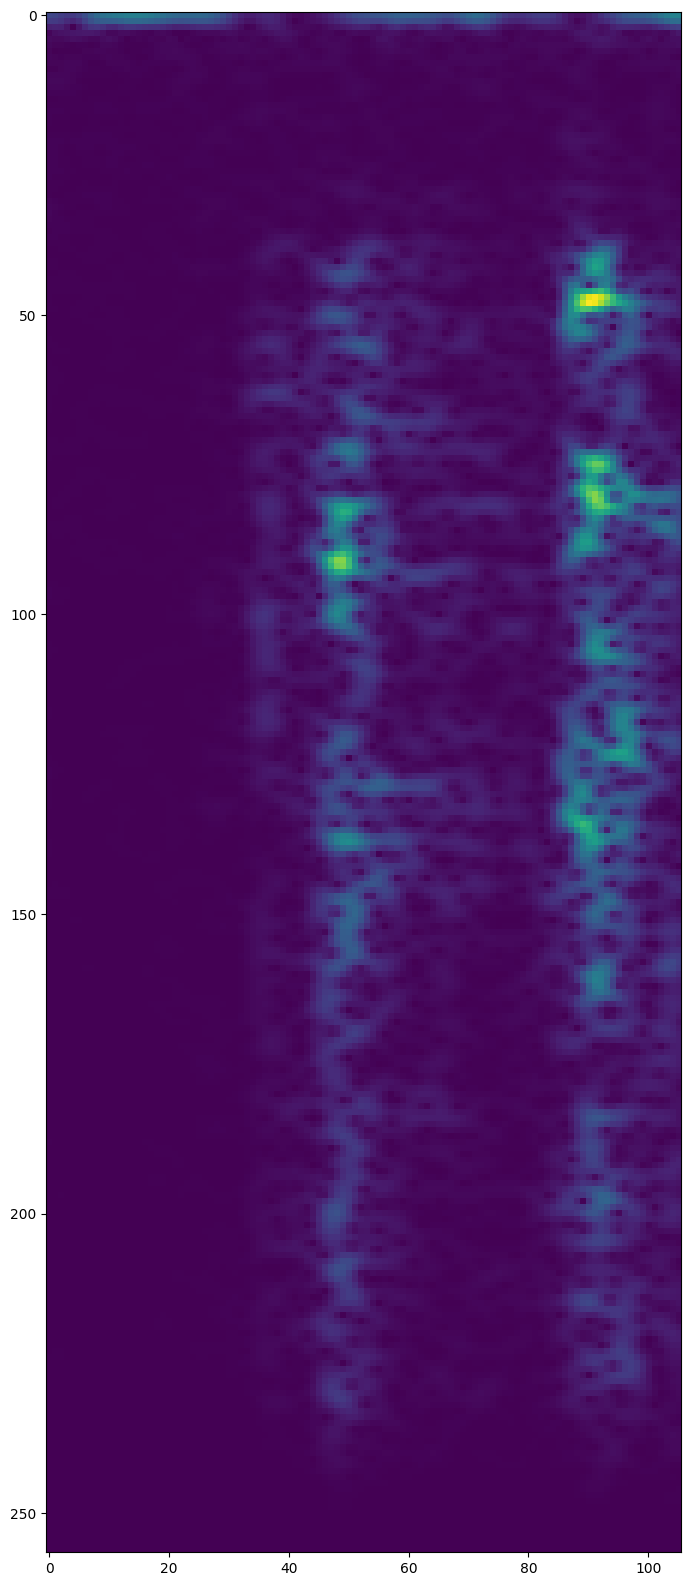

In [155]:
znum = 45
i = np.random.randint(20)
spectrogram, label = preprocess(f'.\Home_Data\Z{znum}\z{i}.wav', 45)
#spectrogram, label = preprocess(f'.\TEMPORARY_CLASSIFICATION_DATA\\test5.wav', 1)

plt.figure(figsize=(10,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Define Architecture

In [7]:
#Check dimensions
samples, labels = train.as_numpy_iterator().next()
print(samples.shape) #number of files in batch, dims
spectro_shape = samples.shape[1:]

(45, 106, 257, 1)


In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, AveragePooling2D

In [143]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=samples.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(16, (10,4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

In [144]:
model.compile('Adam', loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

In [145]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 104, 255, 16)      160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 52, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 43, 124, 16)       10256     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 21, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 20832)             0         
                                                                 
 dense_23 (Dense)            (None, 32)              

In [146]:
hist = model.fit(train, epochs=10, validation_data=test, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
34/34 [==============================] - 11s 290ms/step - loss: 12.3221 - root_mean_squared_error: 15.0321 - mean_absolute_error: 12.8176 - val_loss: 12.3717 - val_root_mean_squared_error: 14.4286 - val_mean_absolute_error: 12.8655
Epoch 2/10
34/34 [==============================] - 9s 279ms/step - loss: 10.3258 - root_mean_squared_error: 12.6837 - mean_absolute_error: 10.8176 - val_loss: 12.1241 - val_root_mean_squared_error: 13.7855 - val_mean_absolute_error: 12.6204
Epoch 3/10
34/34 [==============================] - 9s 276ms/step - loss: 9.6783 - root_mean_squared_error: 11.8515 - mean_absolute_error: 10.1726 - val_loss: 12.7172 - val_root_mean_squared_error: 15.8218 - val_mean_absolute_error: 13.2096
Epoch 4/10
34/34 [==============================] - 9s 277ms/step - loss: 9.6686 - root_mean_squared_error: 12.0926 - mean_absolute_error: 10.1605 - val_loss: 10.5852 - val_root_mean_squared_error: 12.6147 - val_mean_absolute_error: 11.0781
Epoch 5/10
34/34 [===============

In [132]:
hist.history

{'loss': [13.453721046447754,
  10.035812377929688,
  9.212652206420898,
  8.566986083984375,
  7.95535945892334,
  7.621016979217529,
  7.495488166809082],
 'root_mean_squared_error': [16.513914108276367,
  12.452767372131348,
  11.373117446899414,
  10.81160831451416,
  10.304218292236328,
  9.986607551574707,
  9.790042877197266],
 'mean_absolute_error': [13.947790145874023,
  10.526796340942383,
  9.703344345092773,
  9.056875228881836,
  8.444011688232422,
  8.1090087890625,
  7.984327793121338],
 'val_loss': [12.726553916931152,
  11.651906967163086,
  10.066399574279785,
  9.280708312988281,
  8.570005416870117,
  8.806389808654785,
  9.00423812866211],
 'val_root_mean_squared_error': [15.466644287109375,
  13.515840530395508,
  12.203499794006348,
  11.610367774963379,
  10.791996002197266,
  11.156309127807617,
  11.474989891052246],
 'val_mean_absolute_error': [13.22001838684082,
  12.146136283874512,
  10.558292388916016,
  9.769217491149902,
  9.062642097473145,
  9.3001985

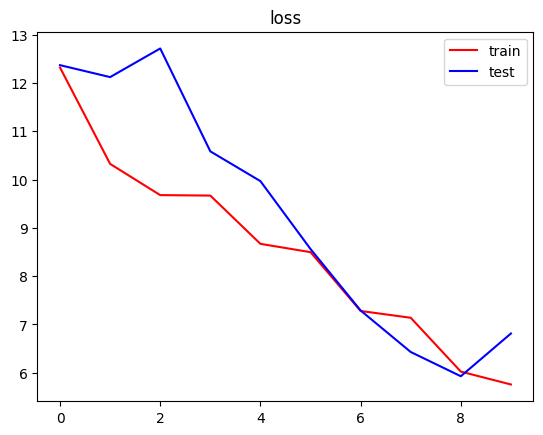

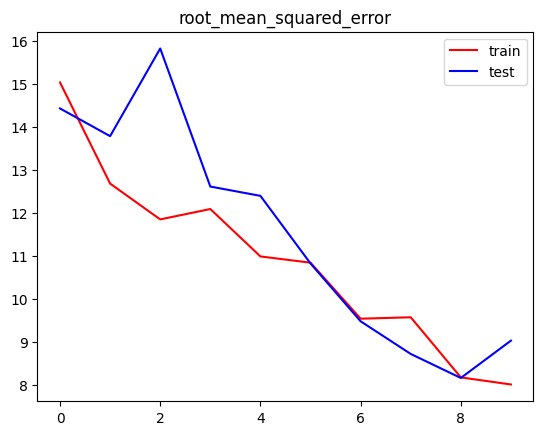

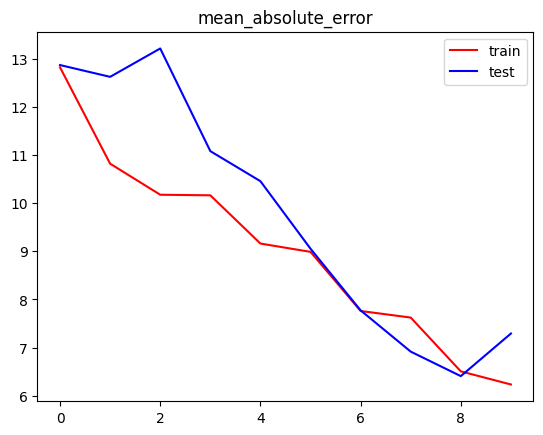

In [147]:
score_names = list(hist.history.keys())
for i in range(len(score_names)//2):
    plt.title(score_names[i])
    plt.plot(hist.history[score_names[i]], 'r', label='train')
    plt.plot(hist.history[score_names[i + len(score_names)//2]], 'b', label='test')
    plt.legend()
    plt.show()

conv2d_18 (3, 3, 1, 16)


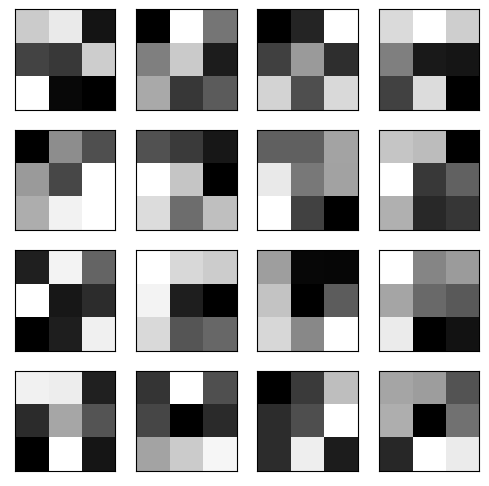

In [148]:
#https://www.youtube.com/watch?v=ho6JXE3EbZ8&ab_channel=DigitalSreeni
#Understand the filters in the model 
#Let us pick the first hidden layer as the layer of interest.
layer = model.layers #Conv layers at 1, 3, 6, 8, 11, 13, 15
nlayer = 0
filters, biases = model.layers[nlayer].get_weights()
print(layer[nlayer].name, filters.shape)

   
# plot filters

fig1=plt.figure(figsize=(6, 6))
columns = 4
rows = 4
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(tf.transpose(f[:, :, 0]), cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()    

conv2d_19 (10, 4, 16, 16)


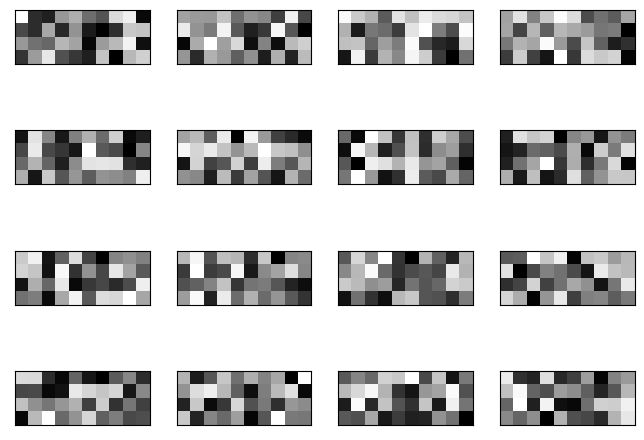

In [150]:
#https://www.youtube.com/watch?v=ho6JXE3EbZ8&ab_channel=DigitalSreeni
#Understand the filters in the model 
#Let us pick the first hidden layer as the layer of interest.
layer = model.layers #Conv layers at 1, 3, 6, 8, 11, 13, 15
nlayer = 2
filters, biases = model.layers[nlayer].get_weights()
print(layer[nlayer].name, filters.shape)

   
# plot filters

fig1=plt.figure(figsize=(8, 6))
columns = 4
rows = 4
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(tf.transpose(f[:, :, 14]), cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()    

Test on new .wav  data

In [79]:
import soundfile as sf
import librosa

sr = 44100
def detect_peaks(signal):
    asignal = np.abs(signal)
    signal_avg = asignal

    detect_min = 0.02 #later i can change this to adapt
    impuls_max_time = 0.4 #s
    #minimal interval for the program to work

    det_peaks_idx = np.empty(0, dtype=int)
    search = True

    for i, s in enumerate(signal_avg):
        if search and s > detect_min:
            #print(f'found i {i} s {s}')
            search = False
            ifin = i + impuls_max_time*sr
            maxs = s
            maxsidx = i
        if not search:
            if s > maxs: 
                maxs = s
                maxsidx = i
            if i > ifin:
                det_peaks_idx = np.append(det_peaks_idx, maxsidx)
                search = True
    if len(det_peaks_idx) == 0: 
        print('no peaks found. try changing detect_min')
    else:
        print(f'{len(det_peaks_idx)} peaks found')
    return det_peaks_idx


tempdir = 'TEMPORARY_CLASSIFICATION_DATA'
def SaveFiles(signal, segment_data):
    path = f'.\{tempdir}'
    for f in os.listdir(path):
        os.remove(os.path.join(path,f))
    os.makedirs(path, exist_ok = True)
    ls = os.listdir(path=path)
    for i,data1 in enumerate(segment_data):
        sf.write(f'{path}\\test{i}.wav', signal[data1[0]:data1[1]], sr)

def Generate_x_vector(n, true_value):
    path = f'.\{tempdir}'
    audio_files = tf.data.Dataset.list_files(path+'\*.wav')
    #add labels (for now just so the code stays the same):
    datatest = tf.data.Dataset.zip((audio_files, tf.data.Dataset.from_tensor_slices(true_value*tf.ones(len(audio_files)))))
    datatest = datatest.map(preprocess)
    datatest = datatest.batch(len(datatest))
    samples, labels = datatest.as_numpy_iterator().next()
    return samples, labels

def ClassifyData(file, true_value=1, printbool = True):    
    #this will only work if data len matches our model
    signal, sr2 = librosa.load(file, sr=sr) 
    signal = np.array(signal)
    det_peaks_idx = detect_peaks(signal)
    delta = 0.04 #s
    impuls_time = 0.15
    dleft = (impuls_time + delta)*sr
    dright = delta*sr
    segment_data = np.array([np.array([p - dleft, p + dright, 0, p]).astype(int) for p in det_peaks_idx])
    n = len(segment_data)
    SaveFiles(signal, segment_data) #maybe i will change this to automatically calculate spectrograms
    x_vec, true_labels = Generate_x_vector(n, true_value)
    yhat = model.predict(x_vec).T
    if printbool:
        print(f'my prediction: {np.mean(yhat)} +- {np.std(yhat)/np.sqrt(n)}.') #for now
    return yhat #mean(yhat)
    




In [61]:
file = './myaudio/testidk.wav'
#file = './myaudio/nagrywka-1-1z.wav'
yhat = ClassifyData(file, 40)
print(f'Full result: {yhat}')

28 peaks found
1/1 [==============================] - 0s 149ms/step
my prediction: 18.36271095275879 +- 1.3867749570500085.
Full result: [[21.606579 34.47563  15.46386  29.339993 12.944913 18.161661 14.679515
  25.7498   10.357717 14.249859 34.523384 16.197912 24.910368  9.299172
  24.103525 15.605334 24.23706  18.824461 17.41834  19.582369 12.476854
  24.55975  12.247945 10.34501   5.638577  9.607118 13.875011 23.67414 ]]


https://www.youtube.com/watch?v=2kSPbH4jWME&ab_channel=Dataquest

In [80]:
import ipywidgets as widgets
from IPython.display import display
from queue import Queue
from threading import Thread

messages = Queue()
recordings = Queue()

record_button = widgets.Button(
    description='Record',
    disabled=False,
    button_style='success',
    tooltip='Record',
    icon='microphone'
)

stop_button = widgets.Button(
    description='Stop',
    disabled=False,
    button_style='warning',
    tooltip='Stop',
    icon='stop'
)

analyze_button = widgets.Button(
    description='Analyze',
    disabled=False,
    button_style='primary',
    tooltip='Analyze',
    icon='check'
)

output = widgets.Output()

def start_recording(data):
    messages.put(True)
    
    with output:
        display("Starting...")
        record = Thread(target=record_microphone)
        record.start()

def stop_recording(data):
    with output:
        messages.get()
        display("Stopped.")

def Analyze_recording(data):
    yhat = ClassifyData('TEST_AUDIO.wav', printbool=False)
    with output:
        display(np.around(yhat,3), len(yhat))
        display(f'my prediction: {np.mean(yhat)} +- {np.std(yhat)/np.sqrt(len(yhat))}.')

record_button.on_click(start_recording)
stop_button.on_click(stop_recording)
analyze_button.on_click(Analyze_recording)

display(record_button, stop_button, analyze_button, output)

Button(button_style='success', description='Record', icon='microphone', style=ButtonStyle(), tooltip='Record')

Button(button_style='warning', description='Stop', icon='stop', style=ButtonStyle(), tooltip='Stop')

Button(button_style='primary', description='Analyze', icon='check', style=ButtonStyle(), tooltip='Analyze')

Output()

recording


stopped
12 peaks found
1/1 [==============================] - 0s 79ms/step


recording


stopped
11 peaks found
1/1 [==============================] - 0s 52ms/step


In [64]:
import wave
CHANNELS = 1
FRAME_RATE = 44100
RECORD_SECONDS = 20
AUDIO_FORMAT = pyaudio.paInt16
SAMPLE_SIZE = 2

def record_microphone(chunk=1024):
    p = pyaudio.PyAudio()
    print('recording')
    stream = p.open(format=AUDIO_FORMAT,
                    channels=CHANNELS,
                    rate=FRAME_RATE,
                    input=True,
                    frames_per_buffer=chunk)

    frames = []

    while not messages.empty():
        data = stream.read(chunk)
        frames.append(data)
    stream.stop_stream()
    stream.close()
    p.terminate()
    print('stopped')
    wf = wave.open('TEST_AUDIO.wav', 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(AUDIO_FORMAT))
    wf.setframerate(FRAME_RATE)
    wf.writeframes(b''.join(frames))
    wf.close

In [ ]:
# Install pyaudio from http://people.csail.mit.edu/hubert/pyaudio/
# Find audio device index using this code
import pyaudio
p = pyaudio.PyAudio()
for i in range(p.get_device_count()):
    print(p.get_device_info_by_index(i))

p.terminate()